In [1]:
import os
import sys
import re
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import copy
import pickle
from scipy.optimize import fmin

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append('../../statmechlib')
from statmechlib.read_write import read_vasp
from statmechlib.preprocessing import Trajectory, select_nodes, scale_configuration, pair_dist_cutoff
from statmechlib.preprocessing import pair_dist, force_targ, get_stats_EAM, get_stats_EAM_pairdist
from statmechlib.forcefields import sd2_loss, utot_EAM, ftot_EAM, udif_print, u_core
from statmechlib.preprocessing import universal_eos

In [4]:
target_raw = '../data/target_raw'
target_proc = '../data/target_processed'
working = '../data/working'

In [5]:
n = int((1.45-0.85)/0.05 + 0.01)
reos = np.linspace(0.85, 1.45, n+1)*2.74
#for i, scale in enumerate(np.linspace(0.85, 1.45, 13)):
#    print(round(reos[i], 3), universal_eos(scale, 'W'))

In [6]:
with open(os.path.join(working, 'stats_ready'+'.pickle'), 'rb') as fi:
    stats_ready = pickle.load(fi)

with open(os.path.join(working, 'target_ready'+'.pickle'), 'rb') as fi:
    targ_ready = pickle.load(fi)   

In [7]:
print(stats_ready['hyperparams'])

[2.5, 2.65, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.356, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75]


In [8]:
multi_index = []
multi_index.append([0, 2, 3, 5, 7, 10, 12, 15])
multi_index.append([0, 2, 4, 6, 8, 10, 12, 14])
multi_index.append([0, 2, 4, 6, 8, 11, 13, 15])
multi_index.append([1, 2, 3, 5, 7, 10, 12, 14])
multi_index.append([1, 2, 4, 6, 8, 11, 13, 15])
multi_index.append([1, 2, 4, 6, 9, 11, 13, 15])
multi_index.append([1, 3, 5, 7, 9, 11, 13, 15])

In [9]:
stats_opts = []
for index in multi_index:
    index = np.array([True if i in index else False for i in range(len(stats_ready['hyperparams']))])
    print(np.array(stats_ready['hyperparams'])[index])
    stats_opts.append(select_nodes(stats_ready, index))

[2.5  2.75 3.   3.5  4.   4.5  5.   5.75]
[2.5  2.75 3.25 3.75 4.25 4.5  5.   5.5 ]
[2.5  2.75 3.25 3.75 4.25 4.75 5.25 5.75]
[2.65 2.75 3.   3.5  4.   4.5  5.   5.5 ]
[2.65 2.75 3.25 3.75 4.25 4.75 5.25 5.75]
[2.65  2.75  3.25  3.75  4.356 4.75  5.25  5.75 ]
[2.65  3.    3.5   4.    4.356 4.75  5.25  5.75 ]


In [10]:
#with open(os.path.join(working, "stats_multi.pickle"), 'wb') as fo:
#    pickle.dump(stats_opts, fo)

In [11]:
#with open(os.path.join(working, "target_multi.pickle"), 'wb') as fo:
#    pickle.dump(targ_ready, fo)

In [12]:
# read corresponding parameters
with open(os.path.join(working, 'pars_in'+'.pickle'), 'rb') as fi:
    pars_dict = pickle.load(fi)

pars_in = pars_dict['embed'] + pars_dict['pair']
print(pars_in)

TypeError: list indices must be integers or slices, not str

In [13]:
with open(os.path.join(working, 'stats_multi.pickle'), 'rb') as fi:
    stats_opts = pickle.load(fi)

with open(os.path.join(working, 'target_multi.pickle'), 'rb') as fi:
    targ_ready = pickle.load(fi)   

In [14]:
it = 1 # read in it (independent process)
stats = []
target = []
for key in list(targ_ready.keys()):
    stats.append(stats_opts[it][key])
    target.append(targ_ready[key])

In [15]:
def optimize_EAM(target, stats, ieam, multi_pars, n_b=2):
    
    optimal_parameters = []
    
    for i, pars in enumerate(multi_pars):
        sd_ini = sd2_loss(list(pars), stats, target, utot_EAM, None, [ieam])
        print(i,' sd2: ini', sd_ini, end='')
        output = fmin(sd2_loss, pars, args=(stats, target, utot_EAM, None, [ieam]), maxiter=100000, maxfun=100000, disp=0, full_output=1,ftol=1e-6)
        optimal_parameters.append(tuple([output[1], output[0]]))
        print('sd2: final', output[1])

    n_best = min(n_b, len(optimal_parameters))
                 
    best_params = sorted(optimal_parameters)[:n_best]
    
    print('Best params:', best_params)

    return best_params

In [17]:
multi_pars = []
#multi_pars.append(pars_in)
multi_pars.append([-6.84229349e-01,  1.52487644e-04, -6.56958142e+01,  2.30194161e+01,
       -3.48639263e+00,  3.45615281e+00, -8.88083580e-01, -1.34315802e+00,
        1.24532843e+00, -3.51200974e-01])
for _ in range(4):
    pars = np.array(multi_pars[0])
    pars += np.random.standard_normal(pars.shape)*0.07
    print(pars)
    multi_pars.append(pars)

[-5.69271273e-01 -4.12810104e-02 -6.57309573e+01  2.30013469e+01
 -3.46086724e+00  3.46410846e+00 -9.86134967e-01 -1.47790548e+00
  1.36131132e+00 -4.10122828e-01]
[ -0.73517525   0.0690354  -65.7166675   23.05075603  -3.47655439
   3.40358523  -0.79927141  -1.25276687   1.28386165  -0.31159218]
[-6.69032183e-01  2.03407237e-02 -6.55557560e+01  2.30593435e+01
 -3.59884520e+00  3.41186034e+00 -8.80493017e-01 -1.33323050e+00
  1.29166886e+00 -3.40051394e-01]
[ -0.77410753  -0.07319835 -65.67586825  23.00796199  -3.50833243
   3.53405797  -1.014777    -1.22783772   1.37649661  -0.44718281]


In [23]:
len(target[0]['energy']), [t['weight'] for t in target]

(1138, [1.0, 20.0, 0.5])

In [ ]:
[-1139.2, -906.9778906249999, -1127.13044453125, -1136.3561554687499, -1136.7059554687498, -1190.21418828125]

In [18]:
for ieam in range(6, len(stats_opts[it]['hyperparams'])):
    print('ieam:', ieam)
    for i in range(6):
        best_pars = optimize_EAM(target, stats, ieam, multi_pars)
        multi_pars = [p[1] for p in best_pars]

ieam: 6
0  sd2: ini 2.5940914850240376e-05sd2: final 2.5940765749475113e-05
1  sd2: ini 23.065235057354432

../../statmechlib/statmechlib/forcefields/eam.py:226: RuntimeWarning: overflow encountered in exp
  eee = np.exp(-uuu)


sd2: final 0.00012065003628381049
2  sd2: ini 51.690626539961755

KeyboardInterrupt: 

In [21]:
multi_pars

[array([-3.99852964e-01,  5.19903525e-05, -4.35853845e+01,  1.94974779e+01,
        -3.41125084e+00,  3.29583141e+00, -6.74970661e-01, -1.24161605e+00,
         9.55571732e-01, -2.67603787e-01]),
 array([-3.08115841e-01,  6.08583920e-05, -3.55322048e+01,  1.74741498e+01,
        -3.45456667e+00,  3.55864207e+00, -1.02844413e+00, -1.10262198e+00,
         1.06957764e+00, -3.33945049e-01])]

In [23]:
optimal_parameters = [(2.59409147888659e-05, [-6.84229349e-01,  1.52487644e-04, -6.56958142e+01,  2.30194161e+01,
       -3.48639263e+00,  3.45615281e+00, -8.88083580e-01, -1.34315802e+00,
        1.24532843e+00, -3.51200974e-01]), (2.7011955577216733e-05, [-6.99918428e-01,  1.47393678e-04, -6.03178636e+01,  2.24303464e+01,
       -3.52696503e+00,  3.61710456e+00, -1.18289073e+00, -1.09946985e+00,
        1.18593759e+00, -3.39115303e-01])]

5
Targ: [-1139.2, -906.9778906249999, -1127.13044453125, -1136.3561554687499, -1136.7059554687498]
Model: [-1139.0827274985318, -906.9769431076774, -1127.2501321393033, -1136.3529774826716, -1136.6934736680066]
[0.0390625  0.0462963  0.03937008 0.03875969 0.03875969]
0 2.59409147888659e-05
1 2.7011955577216733e-05


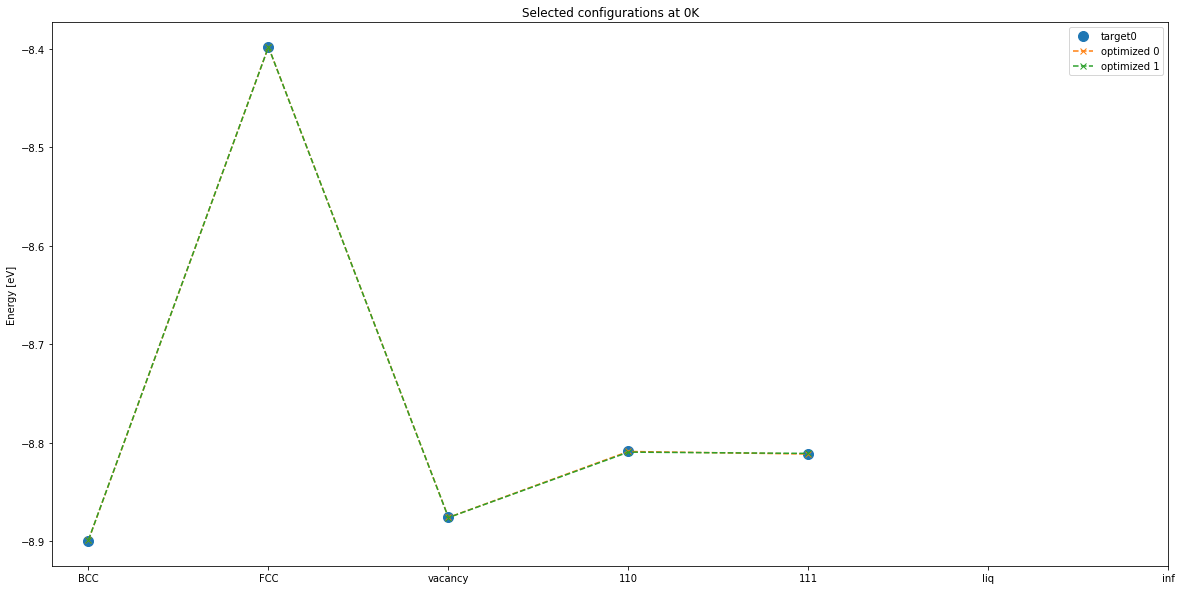

In [24]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_ready['relax']['xyz']])[:-2]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM, [6])
    plt.title('Selected configurations at 0K')
    if i == 0:
        print('Targ:', targ_out[-2][:-2])
        print('Model:', opti_out[-2][:-2])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[-2][:-2]))/nat)
        plt.plot(np.array(targ_out[-2][:-2])/nat, 'o', label='target'+str(i), markersize=10)
        
    if params_uopt[0] > 0.6e-3:
        continue
    #if i != 10 and i != 12:
    #    continue
    print(i, params_uopt[0])

        
    #print('Opti:', [o for o in opti_out[-1][:-1]])
    plt.plot(np.array([o for o in opti_out[-2][:-2]])/nat, 'x--', label='optimized '+str(i))
#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]')
#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.7533)
#plt.ylim(-8.9, -8.35)
#plt.xlim(0, 4)

plt.legend()

13
Targ: [-271.8047221070888, -837.1711089986524, -1079.5267350307165, -1139.2, -1100.8887858645915, -1014.6561261471663, -909.2807161131147, -800.6633444635341, -697.0611202328876, -602.3043063713144, -517.7429994565125, -443.4032853774631, -378.657941519064]
Model: [-272.1045504837473, -836.633369616496, -1078.6255753866221, -1139.0827274985318, -1106.8098947714257, -1009.778209083982, -903.2587489183411, -802.8447965680766, -702.7946269855995, -604.0438657053446, -514.2915036392894, -441.0593604229134, -379.1307207062998]
[0.1015625 0.1015625 0.1015625 0.1015625 0.1015625 0.1015625 0.1015625
 0.1015625 0.1015625 0.1015625 0.1015625 0.1015625 0.1015625]
0 2.59409147888659e-05


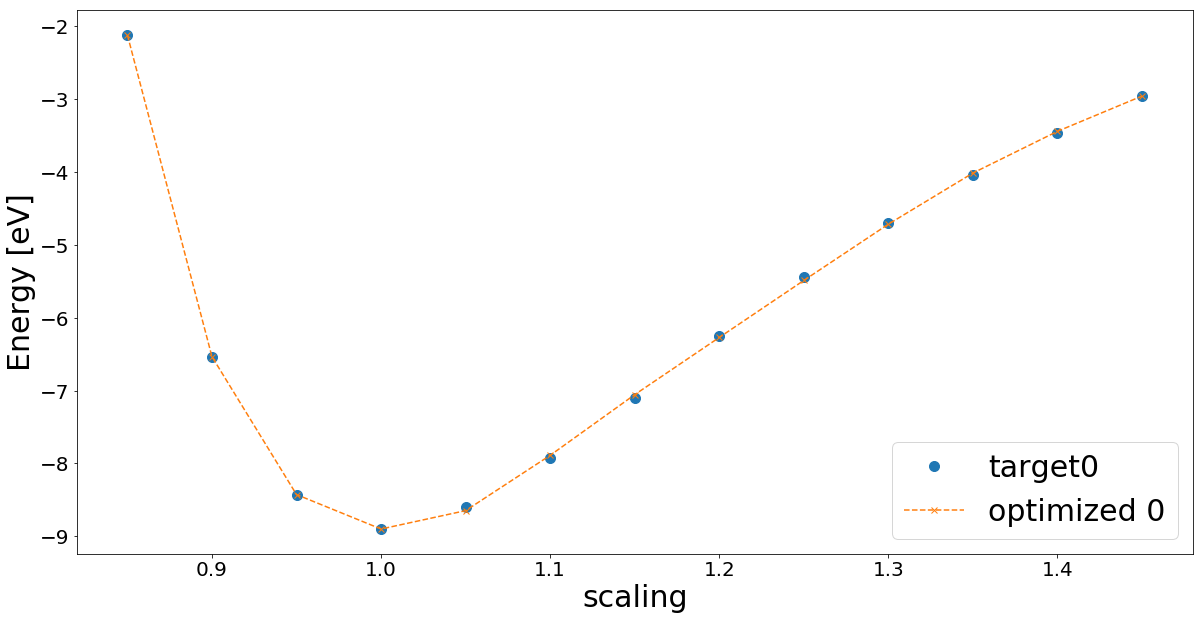

In [84]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_ready['eos']['xyz']])[1:]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM, [6])
    #plt.title('Selected configurations at 0K')
    if i == 0:
        print('Targ:', targ_out[-1][1:])
        print('Model:', opti_out[-1][1:])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[-1][1:]))/nat)
        plt.plot(np.array(reos)/2.74, np.array(targ_out[-1][1:])/nat, 'o', label='target'+str(i), markersize=10)
        
    if params_uopt[0] > 0.6e-3:
        continue
    if i != 0: # and i != 12:
        continue
    print(i, params_uopt[0])

        
    #print('Opti:', [o for o in opti_out[-1][:-1]])
    plt.plot(np.array(reos)/2.74, np.array([o for o in opti_out[-1][1:]])/nat, 'x--', label='optimized '+str(i))
#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

#plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]', fontsize=30)
plt.xlabel('scaling', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.7533)
#plt.ylim(-8.9, -8.35)
#plt.xlim(0, 4)

plt.legend(fontsize=30)
plt.savefig(os.path.join(working, 'eos.png'))

1138
[8.890625 8.890625 8.890625 ... 8.890625 8.890625 8.890625]
0 2.59409147888659e-05
1 2.7011955577216733e-05


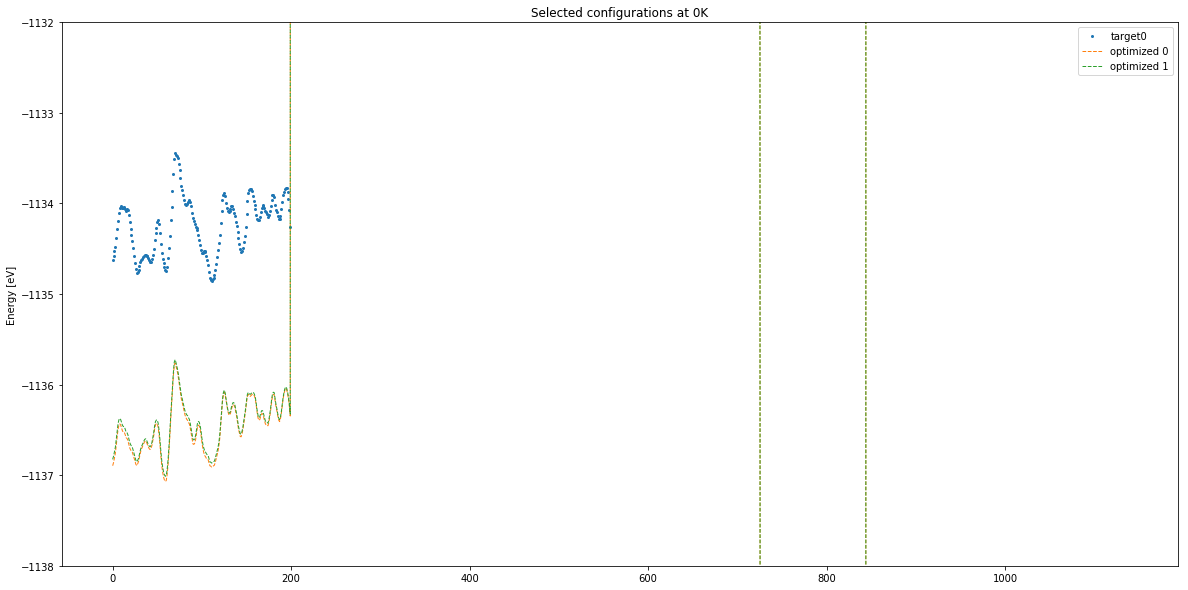

In [76]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_ready['md']['xyz']])[:]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM,[6])
    plt.title('Selected configurations at 0K')
    if i == 0:
        #print('Targ:', targ_out[0][:])
        #print('Model:', opti_out[0][:])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[0][:]))/nat)
        #plt.plot(np.array(targ_out[0][:])/nat, 'o', label='target'+str(i), markersize=10)
        plt.plot(np.array(targ_out[0][:]), 'o', label='target'+str(i), markersize=2)

        
    if params_uopt[0] > 0.6e-3:
        continue
    #if i != 10 and i != 12:
    #    continue
    print(i, params_uopt[0])

    #print('Opti:', [o for o in opti_out[-1][:-1]])
    #plt.plot(np.array([o for o in opti_out[0][:]])/nat, 'x--', label='optimized '+str(i))
    plt.plot(np.array([o for o in opti_out[0][:]]), '--', label='optimized '+str(i), lw=1.0)

#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

#plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]')
#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.533)
#plt.ylim(-8.9, -8.35)

plt.ylim(-1180,-700)
plt.ylim(-1138,-1132)
#plt.ylim(-1000,-900)

plt.legend()

In [49]:
for i, params_uopt in enumerate(optimal_parameters):
    if params_uopt[0] > 1.1e-3:
        continue
    print(i, params_uopt[0], '\n', params_uopt[1])

0 2.59409147888659e-05 
 [-0.684229349, 0.000152487644, -65.6958142, 23.0194161, -3.48639263, 3.45615281, -0.88808358, -1.34315802, 1.24532843, -0.351200974]
1 2.7011955577216733e-05 
 [-0.699918428, 0.000147393678, -60.3178636, 22.4303464, -3.52696503, 3.61710456, -1.18289073, -1.09946985, 1.18593759, -0.339115303]


In [50]:
stats_opt['hyperparams']

NameError: name 'stats_opt' is not defined

In [51]:
stats_opts[it]['hyperparams']

[2.5, 2.75, 3.25, 3.75, 4.25, 4.5, 5.0, 5.5]

In [52]:
pars_out = {}
pars_out['pair_nodes'] = stats_opts[it]['hyperparams']
pars_out['mb_node'] = 6
pars_out['params'] = [optimal_parameters[0]]

In [53]:
optimal_list = []

#with open(os.path.join(working, 'pars_out.pickle'), 'rb') as fi:
#    optimal_list = pickle.load(fi)

#if type(optimal_list) != list:
#    optimal_list = [optimal_list]

optimal_list.append(pars_out)

with open(os.path.join(working, 'pars_out.pickle'), 'wb') as fo:
    pickle.dump(optimal_list, fo)

In [54]:
with open(os.path.join(working, 'pars_out.pickle'), 'rb') as fi:
    optimal_list = pickle.load(fi)

In [55]:
optimal_list

[{'pair_nodes': [2.5, 2.75, 3.25, 3.75, 4.25, 4.5, 5.0, 5.5],
  'mb_node': 6,
  'params': [(2.59409147888659e-05,
    [-0.684229349,
     0.000152487644,
     -65.6958142,
     23.0194161,
     -3.48639263,
     3.45615281,
     -0.88808358,
     -1.34315802,
     1.24532843,
     -0.351200974])]}]

In [56]:
# Total pair potential
pos = targ_ready['relax']['xyz'][0]
bx = targ_ready['relax']['box'][0]
rr, rx = pair_dist_cutoff(pos, bx, 5.5)

In [57]:
# embedding function
F = lambda d, a: a[0]*d**0.5 + a[1]*d + a[2]*d**2

V = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

# Cohesive potential (cubic splines - same form as V)
phi = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

rho = lambda r, aa, kk: sum([a*(rk - r)**3 for a, rk in zip(aa, kk) if r < rk and r > 0.01])

In [58]:
optimal_list[-1]['params'][0][1]

[-0.684229349,
 0.000152487644,
 -65.6958142,
 23.0194161,
 -3.48639263,
 3.45615281,
 -0.88808358,
 -1.34315802,
 1.24532843,
 -0.351200974]

In [59]:
#optimal_parameters.append(tuple([output[1:], params_uopt]))
pair_y = optimal_list[-1]['params'][0][1][2:]
par = optimal_list[-1]['params'][0][1][:2]
many_y = [par[0], 0.0, par[1]]
V_x_r = optimal_list[-1]['pair_nodes'] #stats_opt['hyperparams']
rho_x_r = [V_x_r[optimal_list[-1]['mb_node']]] #stats_opt['hyperparams'][4:5]
rho_x_a = [1.0]

In [60]:
pair_y, many_y, V_x_r, rho_x_r

([-65.6958142,
  23.0194161,
  -3.48639263,
  3.45615281,
  -0.88808358,
  -1.34315802,
  1.24532843,
  -0.351200974],
 [-0.684229349, 0.0, 0.000152487644],
 [2.5, 2.75, 3.25, 3.75, 4.25, 4.5, 5.0, 5.5],
 [5.0])

In [61]:
ene = []
for a in np.linspace(0.5, 2.0, 101):
    z = a*rr
    u_pair = 0.5*np.sum([V(x, pair_y, V_x_r) for x in z.flatten() if x > 0.1])

    u_many = 0.0
    for i in range(z.shape[0]):
        d = np.sum([phi(x, rho_x_a, rho_x_r) for x in z[i] if x > 0.1])
        u_many += F(d, many_y)

    ene.append([a, u_pair, u_many, u_pair+u_many])

ene = np.array(ene)

Text(0,0.5,'U')

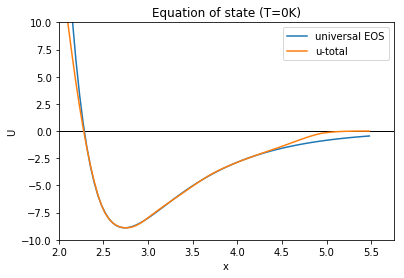

In [62]:
#plt.plot(ene[:,0], ene[:,1]/54, label='pair')
#plt.plot(ene[:,0], ene[:,2]/54, label='manybody')
plt.title('Equation of state (T=0K)')
plt.plot(ene[:,0]*2.74, [universal_eos(x, 'W') for x in ene[:,0]], label='universal EOS')
plt.plot(ene[:,0]*2.74, ene[:,3]/128, label='u-total')
plt.hlines(0.0,0.5,6.0,lw=1)
plt.legend()
plt.xlim(2.0, 5.75)
plt.ylim(-10,10)

plt.xlabel('x')
plt.ylabel(r'U')

In [65]:
#optimal_parameters.append(tuple([output[1:], params_uopt]))
pair_y = optimal_list[-1]['params'][0][1][2:]
par = optimal_list[-1]['params'][0][1][:2]
many_y = [par[0], 0.0, par[1]]
V_x_r = optimal_list[-1]['pair_nodes'] #stats_opt['hyperparams']
rho_x_r = [V_x_r[optimal_list[-1]['mb_node']]] #stats_opt['hyperparams'][4:5]
rho_x_a = [1.0]

In [66]:
V_x_r

[2.5, 2.75, 3.25, 3.75, 4.25, 4.5, 5.0, 5.5]

In [67]:
pair_a = optimal_list[-1]['params'][0][1][2:]#pars_in1[2:]
pair_r = optimal_list[-1]['pair_nodes']

rho_a = [1.0]
rho_r = [pair_r[optimal_list[-1]['mb_node']]]

par = optimal_list[-1]['params'][0][1][:2]
many_a = [par[0], 0.0, par[1]]

In [70]:
# Ranges of densities and separations

nr = 5000
rcut = pair_r[-1]#stats_opt['hyperparams'][-1]
dr = rcut/nr

rhomax = 12.0*phi(1.5, rho_a, rho_r)
print('rhomax:', rhomax)
rhomax = 1000.0
nrho = 5000
drho = rhomax/nrho

ri = 1.0
ro = 2.0

# W properties
na = 74
ma = 183.84
lc = 3.1653
alat = 'bcc'

# System composition
n_el = 1
el_name = ['W']

rhomax: 514.5


In [71]:
def u_trans(r, unucl, ueq, ri=1.0, ro=2.0):
    """Transition between the core and equillibrium potentials"""
    if r < ri:
        return unucl
    elif r < ro:
        x = (ro + ri - 2*r)/(ro - ri)
        eta = 3/16*x**5 - 5/8*x**3 + 15/16*x + 1/2
        return ueq + eta*(unucl - ueq)
    else:
        return ueq

In [73]:
# prepare lists of values
dens = np.linspace(0., rhomax-drho, nrho, endpoint=True)
r = np.linspace(0., rcut-dr, nr, endpoint=True)
r2 = np.linspace(0., rcut, 201)

fembd = [F(d, many_a) for d in dens] # W
edens = np.array([phi(x, rho_a, rho_r) for x in r])

# 1. Cubic spline for r > r_o
f_outer = [V(x, pair_a, pair_r) for i, x in enumerate(r)]
# 2. Repulsive core for r < r_i (precalculate up to r_o)
f_inner = [0.0] + [u_core(x) for x in r[1:]]
# 3. Transition region for r_i < r < r_o
fpair = [x*u_trans(x, f_inner[i], f_outer[i]) for i, x in enumerate(r)]
#fpair = f_outer

In [74]:
# LAMMPS format
pot_path = '../sim/potentials'

with open(os.path.join(pot_path, 'W_lv_1.eam.fs'), 'w') as fo:
    
    # Comment section
    fo.write('Comment 1\n')
    fo.write('Comment 2\n')
    fo.write('Comment 3\n')
    
    # Number of elements
    fo.write(f"{n_el:5d} ")
    for i in range(n_el):
        fo.write(f"{el_name[i]:2}")
    fo.write("\n")
    
    # number of grid points, step size, and cutoff
    fo.write(f"{nrho:5d}{drho:24.16e}{nr:5d}{dr:24.16e}{rcut:24.16e}\n")
    
    # atomic number, mass, lattice size, lattice type
    fo.write(f"{na:5d} {ma:14.4f} {lc:14.4f} {alat:10}\n")
    
    # Embeding function
    for i in range(nrho//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fembd[i*4:i*4+4]))
    
    # Electronic density
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*edens[i*4:i*4+4]))
        
    # Pair potential
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fpair[i*4:i*4+4]))